# 1. LOAD THE DATA


---



In [1]:
import random
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from statsmodels.stats.proportion import proportions_ztest
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 9999999999

In [2]:
!pip install pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [3]:
changes = spark.read.csv('../data/GIT_COMMITS_CHANGES.csv',header=True)
git_commit = spark.read.csv('../data/GIT_COMMITS.csv',header=True)
ref_miner = spark.read.csv('../data/REFACTORING_MINER.csv',header=True)

# 2. DATA EXPLORATION
---



From this data, the most interesting variables are *Lines_added* and *Lines_removed*. For this two variables we will make a deep analysis in order to understand better this attributes.


In [4]:
commits = changes.join(git_commit,'COMMIT_HASH','inner')
commits = commits.select('LINES_ADDED','LINES_REMOVED','COMMIT_MESSAGE','FILE').withColumn('LINES_DIFFERENCE', F.col('LINES_ADDED')-F.col('LINES_REMOVED'))
commits = commits.toPandas()

cols = ['LINES_ADDED','LINES_REMOVED','LINES_DIFFERENCE']
commits[cols] = commits[cols].apply(pd.to_numeric, errors='coerce', axis=1)

cols = ['FILE','COMMIT_MESSAGE']
commits[cols] = commits[cols].astype(str)

array([[<AxesSubplot:title={'center':'LINES_ADDED'}>,
        <AxesSubplot:title={'center':'LINES_REMOVED'}>],
       [<AxesSubplot:title={'center':'LINES_DIFFERENCE'}>,
        <AxesSubplot:>]], dtype=object)

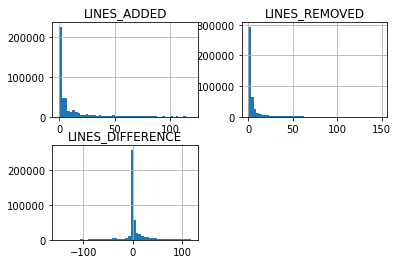

In [5]:
commits[(commits['LINES_ADDED'] < 120) & (commits['LINES_REMOVED'] < 150) & (commits['LINES_DIFFERENCE'] < 600)].hist(bins = 50)

As we can see most of the commits change just a little the code. As we can see the great part of the commits registered just add or remove less than 10 lines. 


<AxesSubplot:>

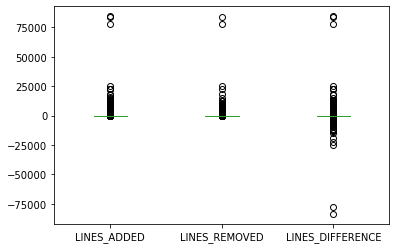

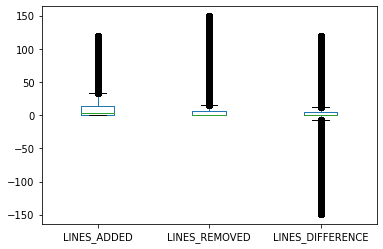

In [6]:
commits.plot.box()
commits[(commits['LINES_ADDED'] < 120) & (commits['LINES_REMOVED'] < 150) & (commits['LINES_DIFFERENCE'] < 600)].plot.box()

We can analize the same fact from another persepctive. Now we can observe through boxplots the same fact. The vast majority of the commits are concentrated near the 0 while the others are detected as outliers. 

In [7]:
words = {}
for idx, row in commits.iterrows():
  msg = row.COMMIT_MESSAGE.split(' ')
  for w in msg:
    if w in words.keys():
      words[w]+=1
    else:
      words[w]=1
words = {k: v for k, v in sorted(words.items(), key=lambda item: -item[1])}

In [8]:
words

{'': 333317,
 'to': 173495,
 'the': 136948,
 'git-svn-id:': 101319,
 '13f79535-47bb-0310-9956-ffa450edef68': 101319,
 'and': 84762,
 'for': 68301,
 'in': 64980,
 'of': 62679,
 'via': 61772,
 'a': 43281,
 'from': 36440,
 '-': 34893,
 'with': 28978,
 ':': 27944,
 'new': 26501,
 'M': 23445,
 'into': 23258,
 'Add': 22818,
 'is': 22039,
 'as': 21541,
 'by': 21469,
 'code': 21150,
 'on': 20006,
 'A': 19916,
 'that': 18685,
 'Move': 18463,
 'Chauhan)': 18035,
 'Ashutosh': 17820,
 'Update': 17816,
 'files': 17458,
 'Remove': 17355,
 'test': 16523,
 'Added': 16174,
 'Apache': 16171,
 'Fix': 15685,
 'Moving': 15418,
 'block': 14265,
 'not': 13575,
 'directory': 13526,
 'use': 13165,
 'be': 12777,
 'all': 12090,
 'source': 11661,
 'Fixed': 11553,
 'it': 11509,
 'Moved': 11396,
 'version': 11260,
 'HCatalog': 11066,
 'support': 10883,
 'tags': 10845,
 'License': 10797,
 'namit)': 10793,
 'no': 10750,
 'package': 10735,
 'tests': 10630,
 'some': 10444,
 'license': 10243,
 'Updated': 10139,
 'trunk'

As we want to predict the message of the commit, we can observe the most common words to see whether we will need any treatment of the strings before building the final model. If we observe the most common words there are non-usual words that will need our attention before building the models. For example, the third most common word is: *git-svn-id:* and the fourth. These are not usual word






In [9]:
words_pos = {}
words_neg = {}

for idx, row in commits.iterrows():
    msg = row.COMMIT_MESSAGE.split(' ')
    if row.LINES_DIFFERENCE > 0:
        for w in msg:  
            if w in words_pos.keys(): words_pos[w]+=1
            else: words_pos[w]=1
    elif row.LINES_DIFFERENCE < 0:
        for w in msg:  
            if w in words_neg.keys(): words_neg[w]+=1
            else: words_neg[w]=1

In [10]:
value_counts1 = 0
for v in words_pos.values():
  value_counts1 += v

value_counts2 = 0
for v in words_neg.values():
  value_counts2 += v

significant_words_pos, significant_words_neg = set(), set()
for word, value in words_pos.items():
    if value < 1: break
    try:
        value2 = words_neg[word]
        count = np.array([value/value_counts1*100, value2/value_counts2*100])
        nobs = np.array([value_counts1,value_counts2])
        _, pval = proportions_ztest(count, nobs)

        if pval < 0.5:
            if value > value2:
                significant_words_pos.add(word)
            else:
                significant_words_neg.add(word)
    except:
        pass

In [11]:
significant_words_pos

{'',
 '13f79535-47bb-0310-9956-ffa450edef68',
 'A',
 'M',
 'and',
 'git-svn-id:',
 'in',
 'the',
 'to'}

In [12]:
significant_words_neg

{'Move',
 'Remove',
 'Removed',
 'Removing',
 'as',
 'block',
 'directory',
 'history.',
 'longer',
 'need',
 'no',
 'obsolete',
 'tags',
 'them',
 "they're",
 'trunk',
 'unused',
 'we'}

In [13]:
len(significant_words_pos), len(significant_words_neg)

(9, 18)

It is clear that some words appear mostly on commits with positive or negative difference in lines added, which leads us to think it is a useful factor in predicting the message in the commit.